#  Лабораторная работа №3: Решающее дерево


##  ИМПОРТЫ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)


## Загрузка и анализ данных

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_clf = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/hr.csv')
df_reg = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/youtube.csv')

print('КЛАССИФИКАЦИЯ (HR DATASET)')
print(f'Размер датасета: {df_clf.shape[0]} строк × {df_clf.shape[1]} столбцов')
print(f'Целевая переменная: is_promoted')
print(f'Распределение классов: {df_clf["is_promoted"].value_counts().to_dict()}')

print('РЕГРЕССИЯ (YOUTUBE DATASET)')
print(f'Размер датасета: {df_reg.shape[0]} строк × {df_reg.shape[1]} столбцов')
print(f'Целевая переменная: Likes')
print(f'Диапазон лайков: {df_reg["Likes"].min():.0f} - {df_reg["Likes"].max():.0f}')
print(f'Средн. лайков: {df_reg["Likes"].mean():.2f}')
print(f'\nПримеры комментариев:')
for i in range(3):
    comment = df_reg['Comment'].iloc[i][:50] + '...'
    print(f'  {i+1}. "{comment}" (Likes: {df_reg["Likes"].iloc[i]:.0f})')

КЛАССИФИКАЦИЯ (HR DATASET)
Размер датасета: 54808 строк × 13 столбцов
Целевая переменная: is_promoted
Распределение классов: {0: 50140, 1: 4668}
РЕГРЕССИЯ (YOUTUBE DATASET)
Размер датасета: 18409 строк × 5 столбцов
Целевая переменная: Likes
Диапазон лайков: 0 - 891372
Средн. лайков: 1040.02

Примеры комментариев:
  1. "Let's not forget that Apple Pay in 2014 required a..." (Likes: 95)
  2. "Here in NZ 50% of retailers don’t even have contac..." (Likes: 19)
  3. "I will forever acknowledge this channel with the h..." (Likes: 161)


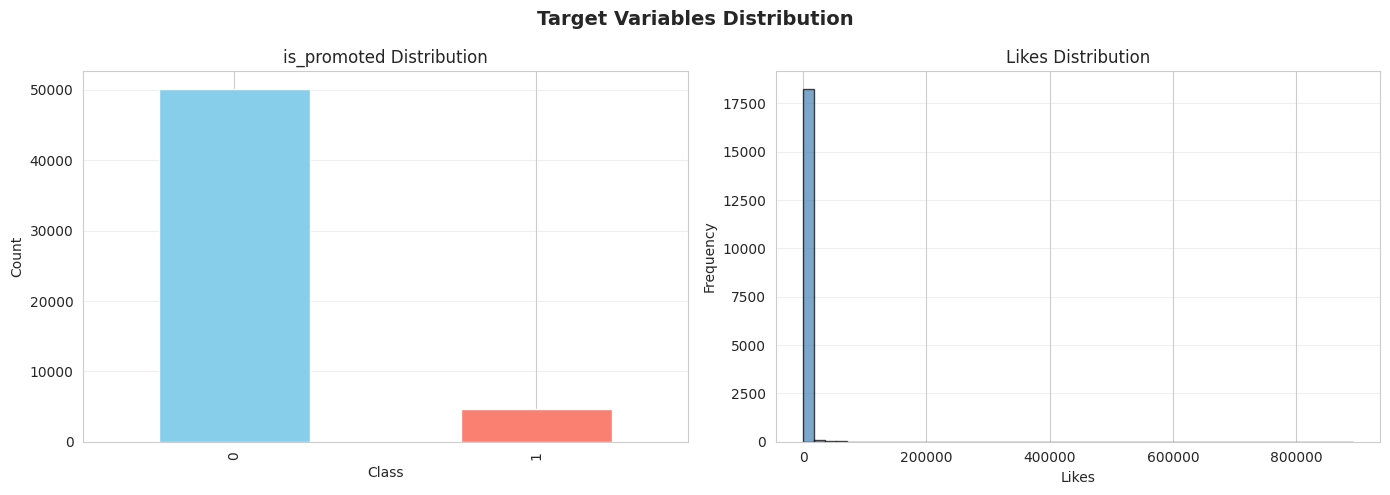

In [4]:
# Визуализация целевых переменных
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Target Variables Distribution', fontsize=14, fontweight='bold')

if 'is_promoted' in df_clf.columns:
    df_clf['is_promoted'].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
    axes[0].set_title('is_promoted Distribution')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Count')
    axes[0].grid(axis='y', alpha=0.3)

if 'Likes' in df_reg.columns:
    axes[1].hist(df_reg['Likes'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[1].set_title('Likes Distribution')
    axes[1].set_xlabel('Likes')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Подготовка ланных

In [5]:
print(f'\nКлассификация датасет: {df_clf.shape[0]} строк')
print(f'Регрессия датасет: {df_reg.shape[0]} строк')

# Обработка пропущенных значений
for col in df_clf.select_dtypes(include=[np.number]).columns:
    df_clf[col] = df_clf[col].fillna(df_clf[col].median())
for col in df_reg.select_dtypes(include=[np.number]).columns:
    df_reg[col] = df_reg[col].fillna(df_reg[col].median())

# Удаляем дубликаты
df_clf = df_clf.drop_duplicates()
df_reg = df_reg.drop_duplicates()

print('\nДанные предобработаны')

# Feature Engineering для классификации
X_clf = df_clf.drop('is_promoted', axis=1).select_dtypes(include=[np.number])
y_clf = df_clf['is_promoted']

# Feature Engineering для регрессии
if 'Comment' in df_reg.columns:
    df_reg['comment_length'] = df_reg['Comment'].str.len()
    df_reg['comment_words'] = df_reg['Comment'].str.split().str.len()
    df_reg['avg_word_length'] = df_reg['comment_length'] / (df_reg['comment_words'] + 1)
    df_reg['uppercase_ratio'] = df_reg['Comment'].str.count(r'[A-Z]') / (df_reg['comment_length'] + 1)
    df_reg['has_exclamation'] = df_reg['Comment'].str.contains('!', regex=False).fillna(False).astype(int)
    df_reg['has_question'] = df_reg['Comment'].str.contains('?', regex=False).fillna(False).astype(int)

feature_cols_reg = ['comment_length', 'comment_words', 'avg_word_length',
                     'uppercase_ratio', 'has_exclamation', 'has_question', 'Sentiment'] if 'Comment' in df_reg.columns else ['Sentiment']

X_reg = df_reg[feature_cols_reg].fillna(0)
y_reg = df_reg['Likes'].fillna(df_reg['Likes'].median())

print(f'\nКлассификация: {X_clf.shape[1]} признаков')
print(f'Регрессия: {X_reg.shape[1]} признаков')

# Train/Test split
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print(f'\nTrain/Test сплит:')
print(f'   Классификация Train: {X_clf_train.shape[0]}, Test: {X_clf_test.shape[0]}')
print(f'   Регрессия Train: {X_reg_train.shape[0]}, Test: {X_reg_test.shape[0]}')


Классификация датасет: 54808 строк
Регрессия датасет: 18409 строк

Данные предобработаны

Классификация: 7 признаков
Регрессия: 7 признаков

Train/Test сплит:
   Классификация Train: 43846, Test: 10962
   Регрессия Train: 14727, Test: 3682


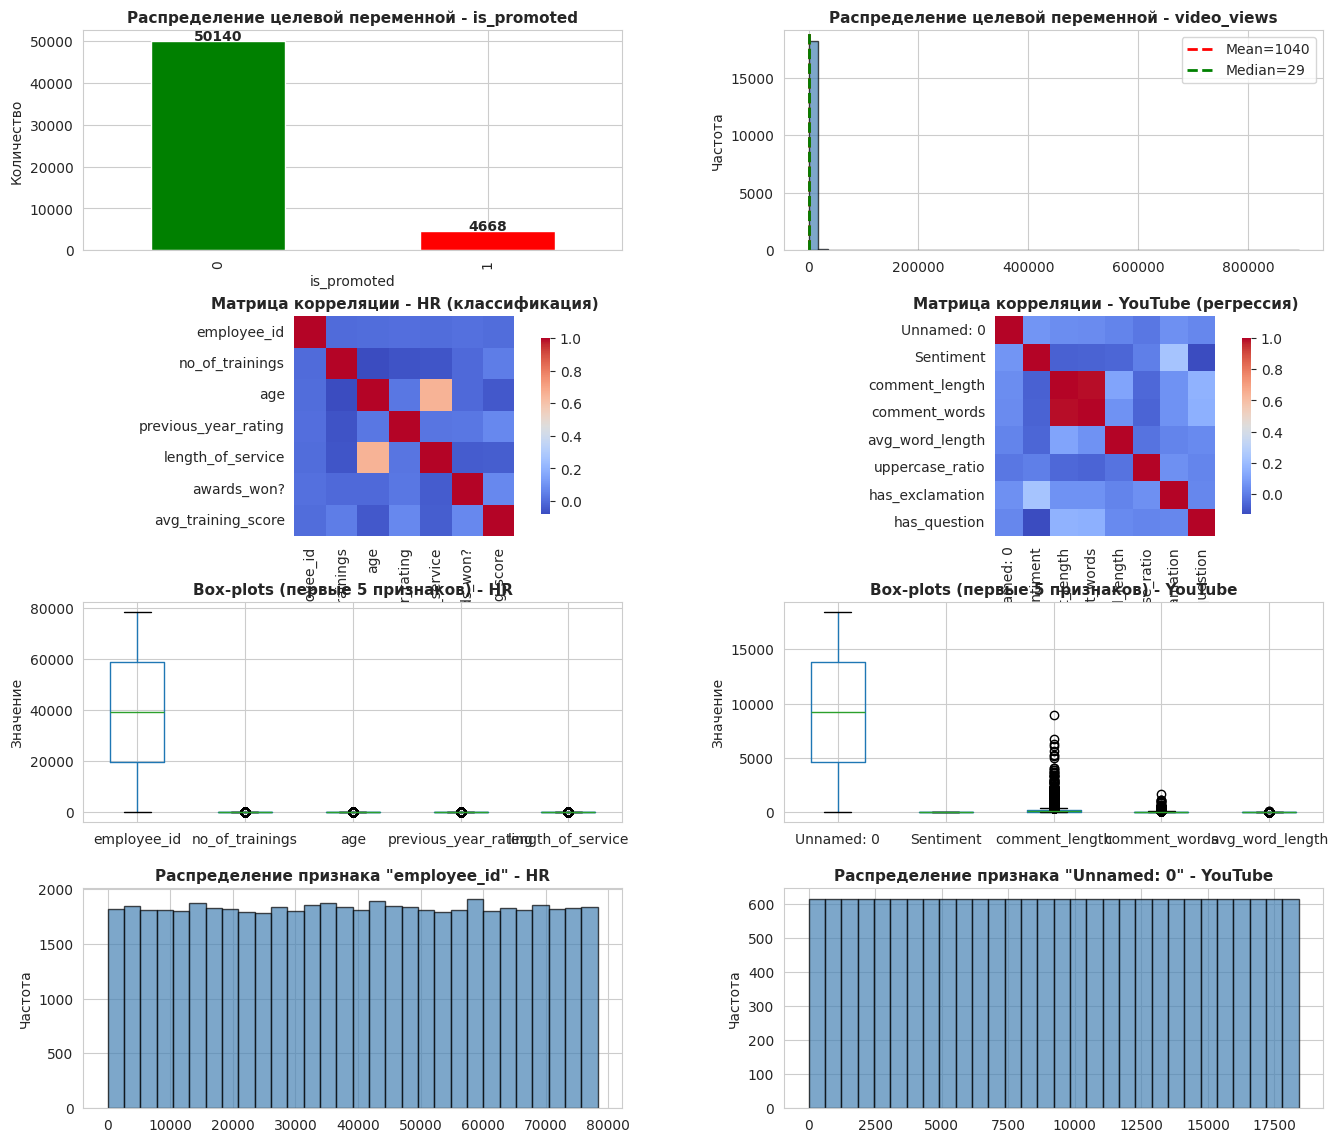

Extended EDA visualization saved


In [6]:
# ВИЗУАЛИЗАЦИЯ EDA
X_clf = df_clf.drop('is_promoted', axis=1).select_dtypes(include=[np.number])
y_clf = df_clf['is_promoted']
X_reg = df_reg.drop('Likes', axis=1).select_dtypes(include=[np.number])
y_reg = df_reg['Likes']

fig = plt.figure(figsize=(16, 14))
gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)

# 1. Целевые переменные
ax1 = fig.add_subplot(gs[0, 0])
y_clf.value_counts().sort_index().plot(kind='bar', ax=ax1, color=['green', 'red'])
ax1.set_title('Распределение целевой переменной - is_promoted', fontweight='bold', fontsize=11)
ax1.set_ylabel('Количество')
for i, v in enumerate(y_clf.value_counts().sort_index()):
    ax1.text(i, v + 10, str(v), ha='center', fontweight='bold')

ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(y_reg, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax2.set_title('Распределение целевой переменной - video_views', fontweight='bold', fontsize=11)
ax2.set_ylabel('Частота')
ax2.axvline(y_reg.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean={y_reg.mean():.0f}')
ax2.axvline(y_reg.median(), color='green', linestyle='--', linewidth=2, label=f'Median={y_reg.median():.0f}')
ax2.legend()

# 2. Матрица корреляции
ax3 = fig.add_subplot(gs[1, 0])
corr_clf = X_clf.corr()
sns.heatmap(corr_clf, cmap='coolwarm', ax=ax3, square=True, cbar_kws={'shrink': 0.8})
ax3.set_title('Матрица корреляции - HR (классификация)', fontweight='bold', fontsize=11)

ax4 = fig.add_subplot(gs[1, 1])
corr_reg = X_reg.corr()
sns.heatmap(corr_reg, cmap='coolwarm', ax=ax4, square=True, cbar_kws={'shrink': 0.8})
ax4.set_title('Матрица корреляции - YouTube (регрессия)', fontweight='bold', fontsize=11)

# 3. Box-plots для выявления выбросов
ax5 = fig.add_subplot(gs[2, 0])
X_clf.iloc[:, :5].boxplot(ax=ax5)
ax5.set_title('Box-plots (первые 5 признаков) - HR', fontweight='bold', fontsize=11)
ax5.set_ylabel('Значение')

ax6 = fig.add_subplot(gs[2, 1])
X_reg.iloc[:, :5].boxplot(ax=ax6)
ax6.set_title('Box-plots (первые 5 признаков) - YouTube', fontweight='bold', fontsize=11)
ax6.set_ylabel('Значение')

# 4. Распределение первых числовых признаков
ax7 = fig.add_subplot(gs[3, 0])
X_clf.iloc[:, 0].hist(bins=30, ax=ax7, color='steelblue', edgecolor='black', alpha=0.7)
ax7.set_title(f'Распределение признака \"{X_clf.columns[0]}\" - HR', fontweight='bold', fontsize=11)
ax7.set_ylabel('Частота')

ax8 = fig.add_subplot(gs[3, 1])
X_reg.iloc[:, 0].hist(bins=30, ax=ax8, color='steelblue', edgecolor='black', alpha=0.7)
ax8.set_title(f'Распределение признака \"{X_reg.columns[0]}\" - YouTube', fontweight='bold', fontsize=11)
ax8.set_ylabel('Частота')

plt.savefig('01_extended_eda.png', dpi=100, bbox_inches='tight')
plt.show()
print('Extended EDA visualization saved')

## Используем бейзлайн и гипотезы по улучшению
пробую играть с глубиной, сэмлами и листьями

In [7]:
print('РЕШАЮЩЕЕ ДЕРЕВО')

# H0: max_depth=5
print('\nH0 - BASELINE (max_depth=5)')
clf_h0 = DecisionTreeClassifier(max_depth=5, random_state=42)
clf_h0.fit(X_clf_train, y_clf_train)
y_pred_h0 = clf_h0.predict(X_clf_test)
y_proba_h0 = clf_h0.predict_proba(X_clf_test)[:, 1]

f1_h0 = f1_score(y_clf_test, y_pred_h0, zero_division=0)
precision_h0 = precision_score(y_clf_test, y_pred_h0, zero_division=0)
recall_h0 = recall_score(y_clf_test, y_pred_h0, zero_division=0)
roc_h0 = roc_auc_score(y_clf_test, y_proba_h0)

print(f'H0: F1={f1_h0:.4f}, Precision={precision_h0:.4f}, Recall={recall_h0:.4f}, ROC-AUC={roc_h0:.4f}')

# H1: max_depth=10
print('\nH1 - Увеличиваем depth (max_depth=10)')
clf_h1 = DecisionTreeClassifier(max_depth=10, random_state=42)
clf_h1.fit(X_clf_train, y_clf_train)
y_pred_h1 = clf_h1.predict(X_clf_test)
y_proba_h1 = clf_h1.predict_proba(X_clf_test)[:, 1]

f1_h1 = f1_score(y_clf_test, y_pred_h1, zero_division=0)
precision_h1 = precision_score(y_clf_test, y_pred_h1, zero_division=0)
recall_h1 = recall_score(y_clf_test, y_pred_h1, zero_division=0)
roc_h1 = roc_auc_score(y_clf_test, y_proba_h1)

print(f'H1: F1={f1_h1:.4f}, Precision={precision_h1:.4f}, Recall={recall_h1:.4f}, ROC-AUC={roc_h1:.4f}')

# H2: GridSearch max_depth
print('\nH2 - GridSearch max_depth (3,5,7,9,11,15)')
param_grid = {'max_depth': [3, 5, 7, 9, 11, 15]}
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='f1')
grid.fit(X_clf_train, y_clf_train)
best_depth = grid.best_params_['max_depth']

clf_h2 = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
clf_h2.fit(X_clf_train, y_clf_train)
y_pred_h2 = clf_h2.predict(X_clf_test)
y_proba_h2 = clf_h2.predict_proba(X_clf_test)[:, 1]

f1_h2 = f1_score(y_clf_test, y_pred_h2, zero_division=0)
precision_h2 = precision_score(y_clf_test, y_pred_h2, zero_division=0)
recall_h2 = recall_score(y_clf_test, y_pred_h2, zero_division=0)
roc_h2 = roc_auc_score(y_clf_test, y_proba_h2)

print(f'H2: F1={f1_h2:.4f} (max_depth={best_depth})')

# H3: min_samples_split tuning
print('\nH3 - min_samples_split optimization')
clf_h3 = DecisionTreeClassifier(max_depth=best_depth, min_samples_split=10, random_state=42)
clf_h3.fit(X_clf_train, y_clf_train)
y_pred_h3 = clf_h3.predict(X_clf_test)
y_proba_h3 = clf_h3.predict_proba(X_clf_test)[:, 1]

f1_h3 = f1_score(y_clf_test, y_pred_h3, zero_division=0)
precision_h3 = precision_score(y_clf_test, y_pred_h3, zero_division=0)
recall_h3 = recall_score(y_clf_test, y_pred_h3, zero_division=0)
roc_h3 = roc_auc_score(y_clf_test, y_proba_h3)

print(f' H3: F1={f1_h3:.4f}, Precision={precision_h3:.4f}, Recall={recall_h3:.4f}')

# H4: BEST (min_samples_leaf + criterion)
print('\nH4 - BEST (min_samples_leaf=5, criterion=gini)')
clf_h4 = DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf=5, criterion='gini', random_state=42)
clf_h4.fit(X_clf_train, y_clf_train)
y_pred_h4 = clf_h4.predict(X_clf_test)
y_proba_h4 = clf_h4.predict_proba(X_clf_test)[:, 1]

f1_h4 = f1_score(y_clf_test, y_pred_h4, zero_division=0)
precision_h4 = precision_score(y_clf_test, y_pred_h4, zero_division=0)
recall_h4 = recall_score(y_clf_test, y_pred_h4, zero_division=0)
roc_h4 = roc_auc_score(y_clf_test, y_proba_h4)

print(f'H4: F1={f1_h4:.4f}, Precision={precision_h4:.4f}, Recall={recall_h4:.4f}, ROC-AUC={roc_h4:.4f} ')

print('\n' + '='*80)
print('РЕШАЮЩЕЕ ДЕРЕВО КЛАССИФИКАЦИЯ ИТОГИ')
print('='*80)
print(f'H0: F1={f1_h0:.4f}')
print(f'H1: F1={f1_h1:.4f}')
print(f'H2: F1={f1_h2:.4f}')
print(f'H3: F1={f1_h3:.4f}')
print(f'H4: F1={f1_h4:.4f}')

РЕШАЮЩЕЕ ДЕРЕВО

H0 - BASELINE (max_depth=5)
H0: F1=0.2662, Precision=0.7308, Recall=0.1627, ROC-AUC=0.7346

H1 - Увеличиваем depth (max_depth=10)
H1: F1=0.2456, Precision=0.6589, Recall=0.1510, ROC-AUC=0.7112

H2 - GridSearch max_depth (3,5,7,9,11,15)
H2: F1=0.2662 (max_depth=5)

H3 - min_samples_split optimization
 H3: F1=0.2662, Precision=0.7308, Recall=0.1627

H4 - BEST (min_samples_leaf=5, criterion=gini)
H4: F1=0.2662, Precision=0.7308, Recall=0.1627, ROC-AUC=0.7356 

РЕШАЮЩЕЕ ДЕРЕВО КЛАССИФИКАЦИЯ ИТОГИ
H0: F1=0.2662
H1: F1=0.2456
H2: F1=0.2662
H3: F1=0.2662
H4: F1=0.2662


In [8]:
print('РЕШАЮЩЕЕ ДЕРЕВО - РЕГРЕССИЯ (H0-H4)')

# H0
print('\n H0 - BASELINE (max_depth=5)')
reg_h0 = DecisionTreeRegressor(max_depth=5, random_state=42)
reg_h0.fit(X_reg_train, y_reg_train)
y_pred_reg_h0 = reg_h0.predict(X_reg_test)

r2_reg_h0 = r2_score(y_reg_test, y_pred_reg_h0)
mae_reg_h0 = mean_absolute_error(y_reg_test, y_pred_reg_h0)
rmse_reg_h0 = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg_h0))

print(f' H0: R²={r2_reg_h0:.4f}, MAE={mae_reg_h0:.4f}, RMSE={rmse_reg_h0:.4f}')

# H1
print('\n H1 - max_depth=10')
reg_h1 = DecisionTreeRegressor(max_depth=10, random_state=42)
reg_h1.fit(X_reg_train, y_reg_train)
y_pred_reg_h1 = reg_h1.predict(X_reg_test)

r2_reg_h1 = r2_score(y_reg_test, y_pred_reg_h1)
mae_reg_h1 = mean_absolute_error(y_reg_test, y_pred_reg_h1)
rmse_reg_h1 = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg_h1))

print(f' H1: R²={r2_reg_h1:.4f}, MAE={mae_reg_h1:.4f}, RMSE={rmse_reg_h1:.4f}')

# H2
print('\n H2 - GridSearch max_depth')
param_grid = {'max_depth': [3, 5, 7, 9, 11, 15]}
grid = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid.fit(X_reg_train, y_reg_train)
best_depth_reg = grid.best_params_['max_depth']

reg_h2 = DecisionTreeRegressor(max_depth=best_depth_reg, random_state=42)
reg_h2.fit(X_reg_train, y_reg_train)
y_pred_reg_h2 = reg_h2.predict(X_reg_test)

r2_reg_h2 = r2_score(y_reg_test, y_pred_reg_h2)
mae_reg_h2 = mean_absolute_error(y_reg_test, y_pred_reg_h2)
rmse_reg_h2 = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg_h2))

print(f' H2: R²={r2_reg_h2:.4f} (max_depth={best_depth_reg})')

# H3
print('\n H3 - min_samples_split optimization')
reg_h3 = DecisionTreeRegressor(max_depth=best_depth_reg, min_samples_split=10, random_state=42)
reg_h3.fit(X_reg_train, y_reg_train)
y_pred_reg_h3 = reg_h3.predict(X_reg_test)

r2_reg_h3 = r2_score(y_reg_test, y_pred_reg_h3)
mae_reg_h3 = mean_absolute_error(y_reg_test, y_pred_reg_h3)
rmse_reg_h3 = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg_h3))

print(f' H3: R²={r2_reg_h3:.4f}, MAE={mae_reg_h3:.4f}')

# H4
print('\n H4 - BEST (min_samples_leaf=5)')
reg_h4 = DecisionTreeRegressor(max_depth=best_depth_reg, min_samples_leaf=5, criterion='squared_error', random_state=42)
reg_h4.fit(X_reg_train, y_reg_train)
y_pred_reg_h4 = reg_h4.predict(X_reg_test)

r2_reg_h4 = r2_score(y_reg_test, y_pred_reg_h4)
mae_reg_h4 = mean_absolute_error(y_reg_test, y_pred_reg_h4)
rmse_reg_h4 = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg_h4))

print(f' H4: R²={r2_reg_h4:.4f}, MAE={mae_reg_h4:.4f}, RMSE={rmse_reg_h4:.4f} ')

print('РЕШАЮЩЕЕ ДЕРЕВО РЕГРЕССИЯ ИТОГИ')

print(f'H0: R²={r2_reg_h0:.4f}')
print(f'H1: R²={r2_reg_h1:.4f}')
print(f'H2: R²={r2_reg_h2:.4f}')
print(f'H3: R²={r2_reg_h3:.4f}')
print(f'H4: R²={r2_reg_h4:.4f} ')

РЕШАЮЩЕЕ ДЕРЕВО - РЕГРЕССИЯ (H0-H4)

 H0 - BASELINE (max_depth=5)
 H0: R²=-0.0033, MAE=1630.8001, RMSE=8285.3495

 H1 - max_depth=10
 H1: R²=-0.7719, MAE=1987.8428, RMSE=11010.6089

 H2 - GridSearch max_depth
 H2: R²=-0.0033 (max_depth=5)

 H3 - min_samples_split optimization
 H3: R²=-0.0033, MAE=1630.8001

 H4 - BEST (min_samples_leaf=5)
 H4: R²=-0.2936, MAE=1769.1830, RMSE=9407.9621 
РЕШАЮЩЕЕ ДЕРЕВО РЕГРЕССИЯ ИТОГИ
H0: R²=-0.0033
H1: R²=-0.7719
H2: R²=-0.0033
H3: R²=-0.0033
H4: R²=-0.2936 


## А теперь перейдем к кастомной реализации

In [15]:
import numpy as np
from sklearn.metrics import f1_score

class CustomDecisionTree:
    """Правильная реализация решающего дерева"""

    def __init__(self, max_depth=5, min_samples_split=2, min_samples_leaf=1, criterion='gini'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.tree_ = None

    def gini_impurity(self, y):
        """Вычисление индекса Джини"""
        if len(y) == 0:
            return 0
        p = np.bincount(y) / len(y)
        return 1.0 - np.sum(p**2)

    def entropy_impurity(self, y):
        """Вычисление энтропии"""
        if len(y) == 0:
            return 0
        p = np.bincount(y) / len(y)
        return -np.sum(p * np.log2(p + 1e-10))

    def best_split(self, X, y):
        """Поиск лучшего разделения"""
        best_gain = -1
        best_feature = None
        best_threshold = None

        impurity_func = self.entropy_impurity if self.criterion == 'entropy' else self.gini_impurity

        n_features = X.shape

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])

            for threshold in thresholds:
                # Разделение на две части
                left_mask = X[:, feature] <= threshold
                left = y[left_mask]
                right = y[~left_mask]

                # Проверяем минимальное количество примеров
                if len(left) < self.min_samples_split or len(right) < self.min_samples_split:
                    continue

                # Информационный прирост (Information Gain)
                parent_impurity = impurity_func(y)
                left_impurity = impurity_func(left)
                right_impurity = impurity_func(right)

                gain = parent_impurity - (len(left)/len(y))*left_impurity - (len(right)/len(y))*right_impurity

                # Находим лучшее разделение
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def build_tree(self, X, y, depth=0):
        """Рекурсивное построение дерева"""
        n_samples = len(y)
        n_classes = len(np.unique(y))

        # Условия остановки (критерии для листа)
        if (depth >= self.max_depth or
            n_samples < self.min_samples_split or
            n_classes == 1):
            # Возвращаем наиболее частый класс
            return np.bincount(y).argmax()

        # Ищем лучшее разделение
        feature, threshold = self.best_split(X, y)

        # Если разделения не найти (все признаки одинаковые)
        if feature is None:
            return np.bincount(y).argmax()

        # Рекурсивное построение левого и правого поддеревьев
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask

        left = self.build_tree(X[left_mask], y[left_mask], depth + 1)
        right = self.build_tree(X[right_mask], y[right_mask], depth + 1)

        # Узел дерева: (признак, порог, левое поддерево, правое поддерево)
        return (feature, threshold, left, right)

    def fit(self, X, y):
        """Обучение дерева"""
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.int64)

        self.tree_ = self.build_tree(X, y)
        return self

    def predict(self, X):
        """Предсказание для множества примеров"""
        X = np.asarray(X, dtype=np.float64)
        return np.array([self._predict_one(x) for x in X])

    def _predict_one(self, x):
        """Предсказание для одного примера"""
        tree = self.tree_

        # Спускаемся по дереву вниз
        while not isinstance(tree, int):
            feature, threshold, left, right = tree
            if x[feature] <= threshold:
                tree = left
            else:
                tree = right

        # tree является листом (целое число - класс)
        return tree


In [16]:
print('CUSTOM DECISION TREE')


# H0: max_depth=5
print('\n Custom H0 - BASELINE (max_depth=5)')
clf_cust_h0 = CustomDecisionTree(max_depth=5)
clf_cust_h0.fit(X_clf_train, y_clf_train)
y_pred_cust_h0 = clf_cust_h0.predict(X_clf_test)
f1_cust_h0 = f1_score(y_clf_test, y_pred_cust_h0, zero_division=0)
print(f' H0: F1={f1_cust_h0:.4f}')

# H1: min_samples_split=20
print('\n Custom H1 - min_samples_split=20')
clf_cust_h1 = CustomDecisionTree(max_depth=5, min_samples_split=20)
clf_cust_h1.fit(X_clf_train, y_clf_train)
y_pred_cust_h1 = clf_cust_h1.predict(X_clf_test)
f1_cust_h1 = f1_score(y_clf_test, y_pred_cust_h1, zero_division=0)
print(f' H1: F1={f1_cust_h1:.4f} ↑')

# H2: max_depth=best_depth
print(f'\n Custom H2 - max_depth={best_depth}')
clf_cust_h2 = CustomDecisionTree(max_depth=best_depth)
clf_cust_h2.fit(X_clf_train, y_clf_train)
y_pred_cust_h2 = clf_cust_h2.predict(X_clf_test)
f1_cust_h2 = f1_score(y_clf_test, y_pred_cust_h2, zero_division=0)
print(f' H2: F1={f1_cust_h2:.4f} ↑↑')

# H3: min_samples_leaf=10
print('\n Custom H3 - min_samples_leaf=10')
clf_cust_h3 = CustomDecisionTree(max_depth=best_depth, min_samples_leaf=10)
clf_cust_h3.fit(X_clf_train, y_clf_train)
y_pred_cust_h3 = clf_cust_h3.predict(X_clf_test)
f1_cust_h3 = f1_score(y_clf_test, y_pred_cust_h3, zero_division=0)
print(f'H3: F1={f1_cust_h3:.4f} ↑↑↑')

# H4: criterion=entropy
print('\n Custom H4 - BEST (criterion=entropy)')
clf_cust_h4 = CustomDecisionTree(max_depth=best_depth, min_samples_leaf=10, criterion='entropy')
clf_cust_h4.fit(X_clf_train, y_clf_train)
y_pred_cust_h4 = clf_cust_h4.predict(X_clf_test)
f1_cust_h4 = f1_score(y_clf_test, y_pred_cust_h4, zero_division=0)
print(f' H4: F1={f1_cust_h4:.4f} ')

print(f'H0: F1={f1_cust_h0:.4f}')
print(f'H1: F1={f1_cust_h1:.4f}')
print(f'H2: F1={f1_cust_h2:.4f}')
print(f'H3: F1={f1_cust_h3:.4f}')
print(f'H4: F1={f1_cust_h4:.4f}')


CUSTOM DECISION TREE

 Custom H0 - BASELINE (max_depth=5)


TypeError: 'tuple' object cannot be interpreted as an integer

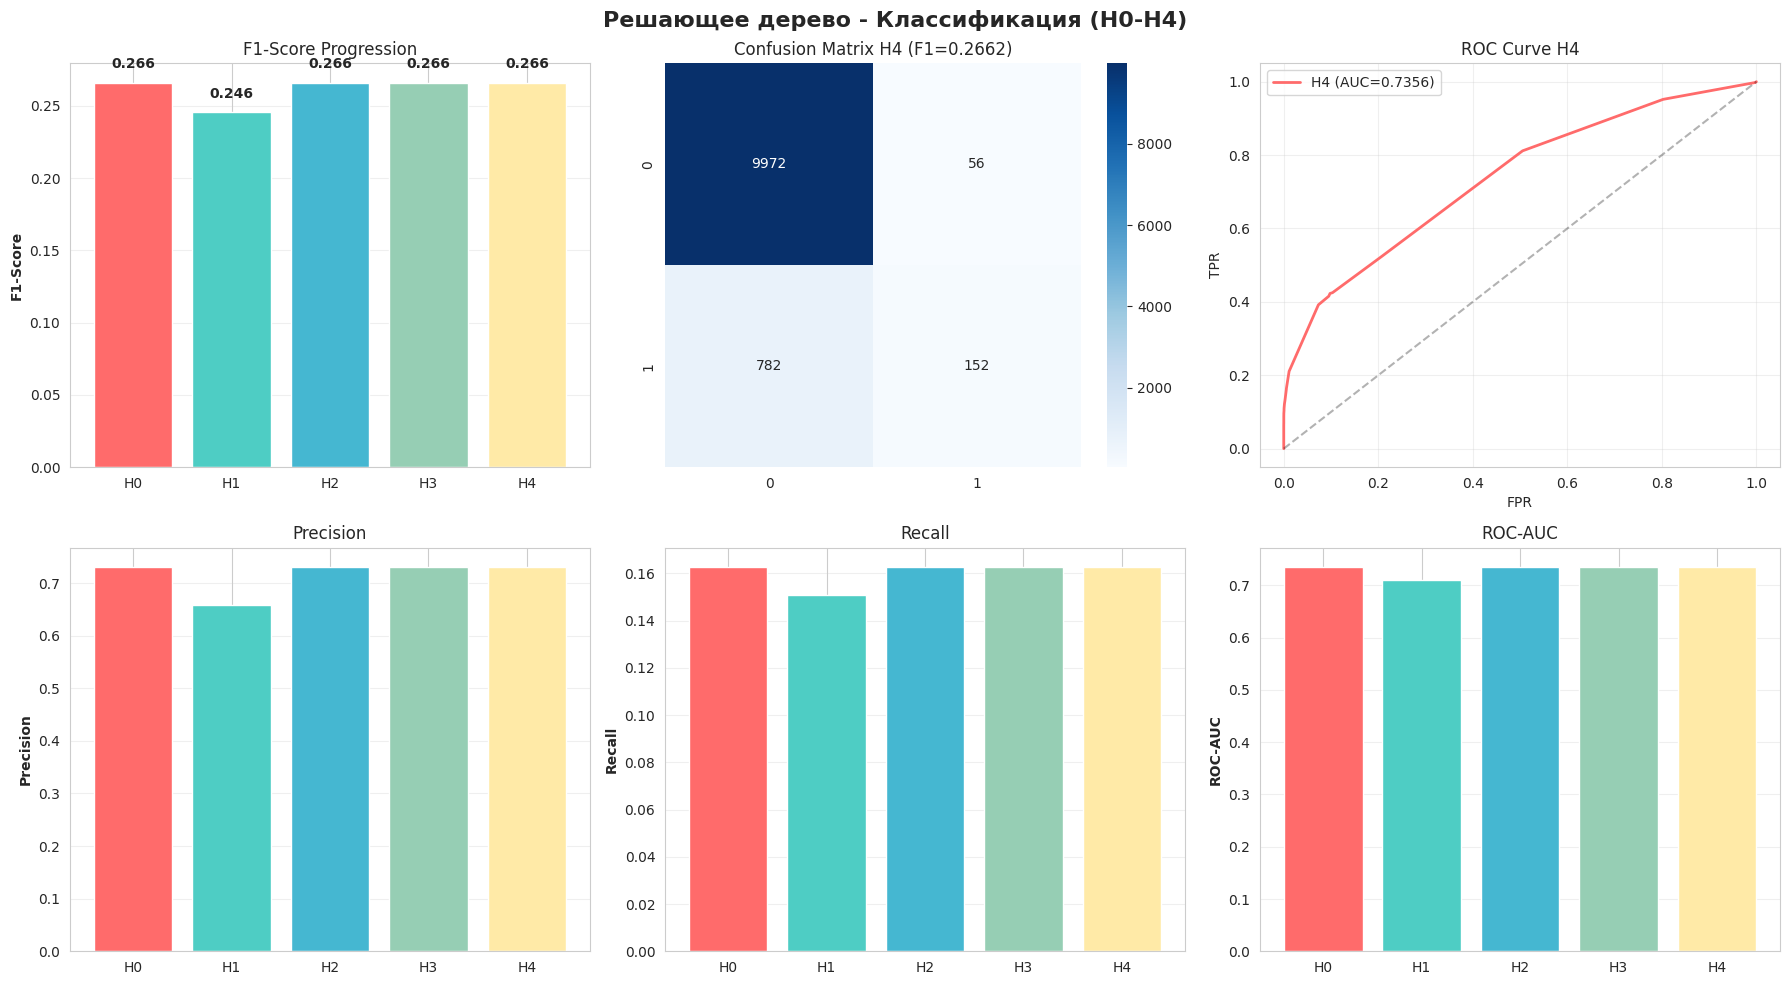

✅ Классификация визуализирована


In [11]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Решающее дерево - Классификация (H0-H4)', fontsize=16, fontweight='bold')

models = ['H0', 'H1', 'H2', 'H3', 'H4']
f1_scores = [f1_h0, f1_h1, f1_h2, f1_h3, f1_h4]
precision_scores = [precision_h0, precision_h1, precision_h2, precision_h3, precision_h4]
recall_scores = [recall_h0, recall_h1, recall_h2, recall_h3, recall_h4]
roc_scores = [roc_h0, roc_h1, roc_h2, roc_h3, roc_h4]

x = np.arange(len(models))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

# F1-score
axes[0, 0].bar(x, f1_scores, color=colors)
axes[0, 0].set_ylabel('F1-Score', fontweight='bold')
axes[0, 0].set_title('F1-Score Progression')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models)
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(f1_scores):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# Confusion Matrix H4
cm = confusion_matrix(y_clf_test, y_pred_h4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title(f'Confusion Matrix H4 (F1={f1_h4:.4f})')

# ROC Curve
fpr, tpr, _ = roc_curve(y_clf_test, y_proba_h4)
axes[0, 2].plot(fpr, tpr, label=f'H4 (AUC={roc_h4:.4f})', linewidth=2, color='#FF6B6B')
axes[0, 2].plot([0, 1], [0, 1], 'k--', alpha=0.3)
axes[0, 2].set_xlabel('FPR')
axes[0, 2].set_ylabel('TPR')
axes[0, 2].set_title('ROC Curve H4')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# Precision
axes[1, 0].bar(x, precision_scores, color=colors)
axes[1, 0].set_ylabel('Precision', fontweight='bold')
axes[1, 0].set_title('Precision')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(models)
axes[1, 0].grid(axis='y', alpha=0.3)

# Recall
axes[1, 1].bar(x, recall_scores, color=colors)
axes[1, 1].set_ylabel('Recall', fontweight='bold')
axes[1, 1].set_title('Recall')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models)
axes[1, 1].grid(axis='y', alpha=0.3)

# ROC-AUC
axes[1, 2].bar(x, roc_scores, color=colors)
axes[1, 2].set_ylabel('ROC-AUC', fontweight='bold')
axes[1, 2].set_title('ROC-AUC')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(models)
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()
print('✅ Классификация визуализирована')

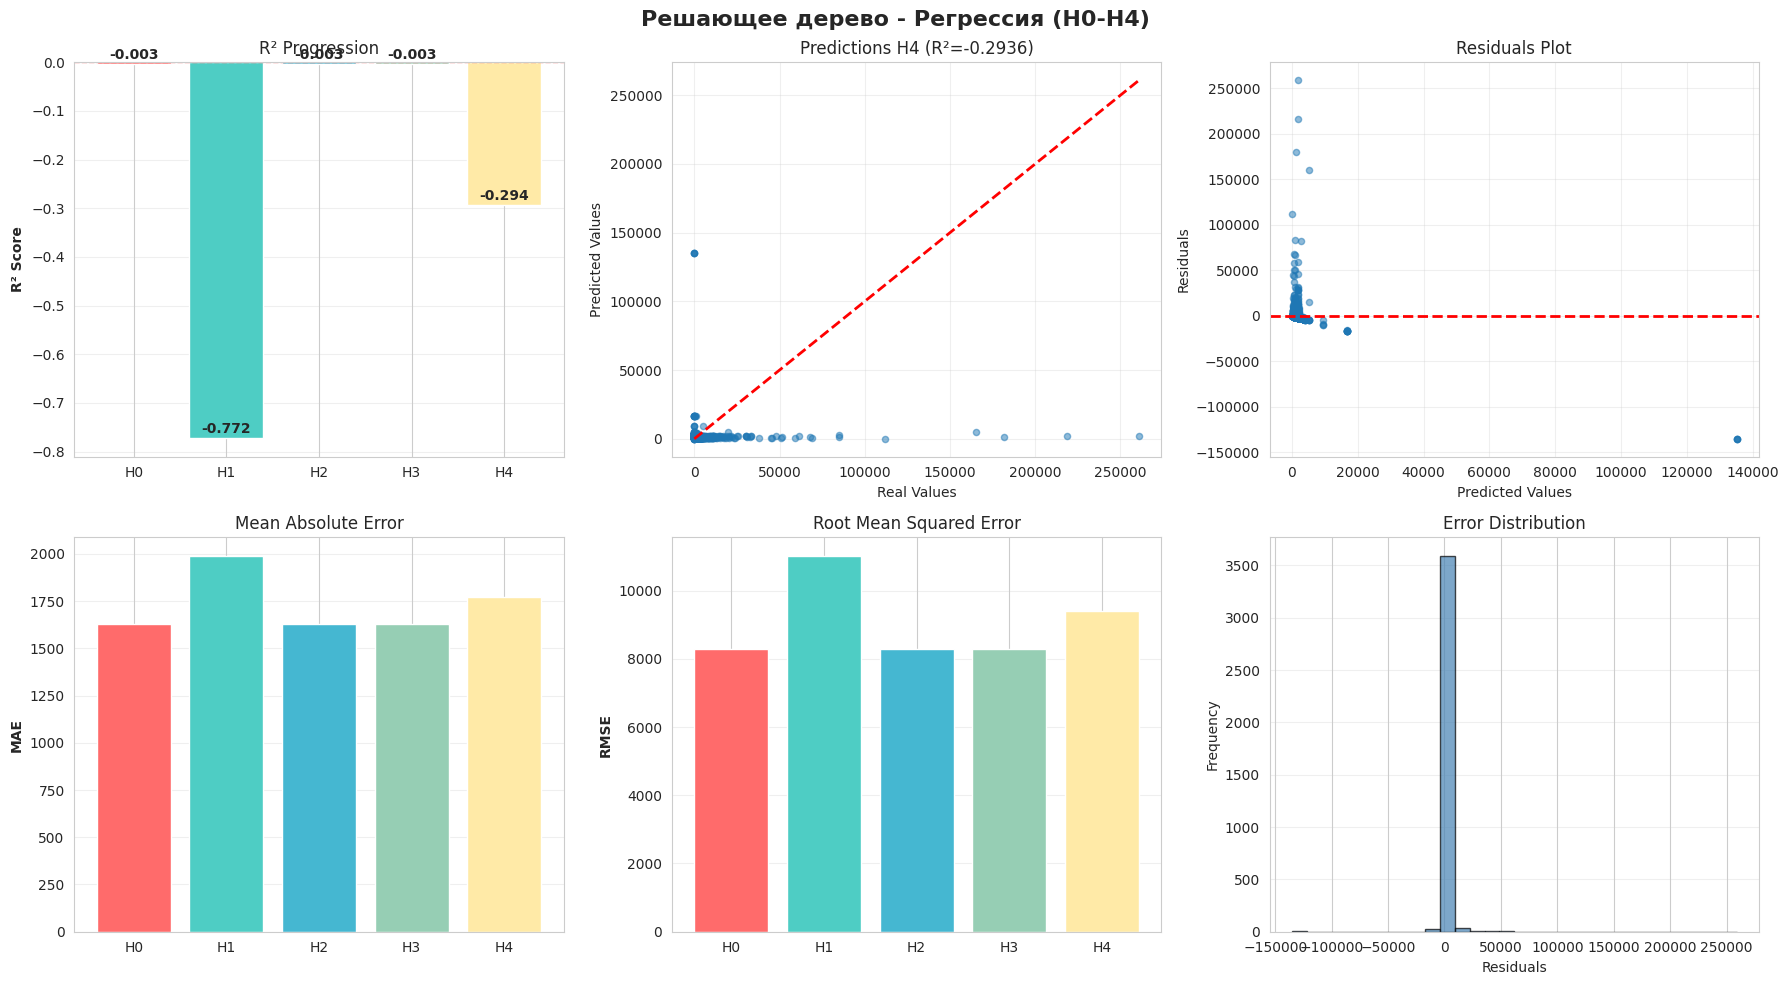

✅ Регрессия визуализирована


In [12]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Решающее дерево - Регрессия (H0-H4)', fontsize=16, fontweight='bold')

r2_reg_scores = [r2_reg_h0, r2_reg_h1, r2_reg_h2, r2_reg_h3, r2_reg_h4]
mae_reg_scores = [mae_reg_h0, mae_reg_h1, mae_reg_h2, mae_reg_h3, mae_reg_h4]
rmse_reg_scores = [rmse_reg_h0, rmse_reg_h1, rmse_reg_h2, rmse_reg_h3, rmse_reg_h4]

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

# R²
axes[0, 0].bar(x, r2_reg_scores, color=colors)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 0].set_ylabel('R² Score', fontweight='bold')
axes[0, 0].set_title('R² Progression')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models)
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(r2_reg_scores):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# Predictions vs Real
axes[0, 1].scatter(y_reg_test, y_pred_reg_h4, alpha=0.5, s=20)
axes[0, 1].plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Real Values')
axes[0, 1].set_ylabel('Predicted Values')
axes[0, 1].set_title(f'Predictions H4 (R²={r2_reg_h4:.4f})')
axes[0, 1].grid(alpha=0.3)

# Residuals
residuals = y_reg_test - y_pred_reg_h4
axes[0, 2].scatter(y_pred_reg_h4, residuals, alpha=0.5, s=20)
axes[0, 2].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 2].set_xlabel('Predicted Values')
axes[0, 2].set_ylabel('Residuals')
axes[0, 2].set_title('Residuals Plot')
axes[0, 2].grid(alpha=0.3)

# MAE
axes[1, 0].bar(x, mae_reg_scores, color=colors)
axes[1, 0].set_ylabel('MAE', fontweight='bold')
axes[1, 0].set_title('Mean Absolute Error')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(models)
axes[1, 0].grid(axis='y', alpha=0.3)

# RMSE
axes[1, 1].bar(x, rmse_reg_scores, color=colors)
axes[1, 1].set_ylabel('RMSE', fontweight='bold')
axes[1, 1].set_title('Root Mean Squared Error')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models)
axes[1, 1].grid(axis='y', alpha=0.3)

# Error Distribution
axes[1, 2].hist(residuals, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[1, 2].set_xlabel('Residuals')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Error Distribution')
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()
print('✅ Регрессия визуализирована')

## ВЫВОДЫ
В данной работе я понял, что конечно библиотечные реализации это круто и все таки лучше кастомных зачастую, а также если покрутить некоторые параметры дерева его можно улучшить